## Installation required in Colab

In [1]:
# ! git clone https://github.com/shaoanlu/diffusion_policy_quadrotor.git

In [2]:
# %cd diffusion_policy_quadrotor
# %ls

In [3]:
# %%capture
# !pip3 install torch==1.13.1 torchvision==0.14.1 diffusers==0.18.2 jax==0.4.23 jaxlib==0.4.23

## Description

This notebook demonstrate using a diffusion policy controller to drive a quadrotor moving from (0, 0) to (5, 5) with random circle obstacles presented.

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import os
import torch
import yaml
import collections
from tqdm.auto import tqdm
import gdown

/home/yif/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from utils.normalizers import LinearNormalizer
from core.controllers.ee2d_diffusion_policy import EscapeEnergy2DDiffusionPolicy, build_networks_from_config, build_noise_scheduler_from_config
from core.controllers.ee2d_guidance import EscapeEnergy2DGuidanceController
# from core.controllers.quadrotor_clf_cbf_qp import QuadrotorCLFCBFController
# from core.env.planar_quadrotor import PlanarQuadrotorEnv
# from utils.visualization import visualize_quadrotor_simulation_result

## Load the config file

In [7]:
with open("config/config_ee2d.yaml", "r") as file:
    config = yaml.safe_load(file)

# Whether to use a finetuned model trained following tricks mentioned in
# [Fine-Tuning Image-Conditional Diffusion Models is Easier than You Think](https://arxiv.org/abs/2409.11355)
use_single_step_inference = config.get("controller").get("common").get("use_single_step_inference", False)

## Instantiate the controller

In [8]:
torch.cuda.is_available() # TODO

True

In [9]:
# clf_cbf_controller = QuadrotorCLFCBFController(config=config)
ee2d_guidance_controller = EscapeEnergy2DGuidanceController(config=config)

controller = EscapeEnergy2DDiffusionPolicy(
    model=build_networks_from_config(config),
    noise_scheduler=build_noise_scheduler_from_config(config),
    normalizer=LinearNormalizer(),
    ee2d_guidance=ee2d_guidance_controller,  # set as clf_cbf_controller to enable CLF-CBF traj refinement
    config=config,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

## Download and load pretrained weights

In [10]:
ckpts_path = "train/ckpt_ep119_fixed_obstacles_0.00517loss.ckpt"
controller.load_weights(ckpts_path)

## Run simulation

In [11]:
def inference(state, centers, rads, max_steps=20, take_only_first_action=False):
    # data preparation
    # print(f"Start state: {state}")
    states = [state]  # `states` is a list containing the states over time
    # print(f"centers: {centers}, rads: {rads}")
    obs_encode = np.hstack([centers, rads]).flatten()
    obs = {
        "state": collections.deque([state] * controller.obs_horizon, maxlen=controller.obs_horizon),
        "obs_encode": [obs_encode],
    }

    # termination params
    done = False
    step_idx = 0
    with tqdm(total=max_steps, desc="Eval") as pbar:
        while not done:
            # controller inference
            action = controller.predict_action(obs)
            
            # execute action_horizon steps without replanning
            # print(f"Step {step_idx}")
            # print(f"state: {state}, action0: {action[0]}")
            # print(f"obs ", obs["state"])
            # print(f"!!!!!!action: {action.shape}")
            for i in range(action.shape[0]):
                # print(f"action {i}: {action[i]}")
                state = action[i]
                # save observations and controls
                obs["state"].append(state.copy())
                states.append(state.copy())

                # update progress bar
                step_idx += 1
                pbar.update(1)
                if step_idx > max_steps:
                    done = True
                if take_only_first_action or done:
                    break
    return states

In [17]:
from dataset.escape_from_u_generator import generate_u_obstacles
np.random.seed(124)

# Env parameters
max_steps = 20

# get first observation
centers, rads, start_pos, goal_pos = generate_u_obstacles()
rads = rads[:,0].reshape(-1,1)

# run inference
states = inference(start_pos, centers, rads, max_steps=max_steps, take_only_first_action=1)

Eval: 21it [00:16,  1.29it/s]                        


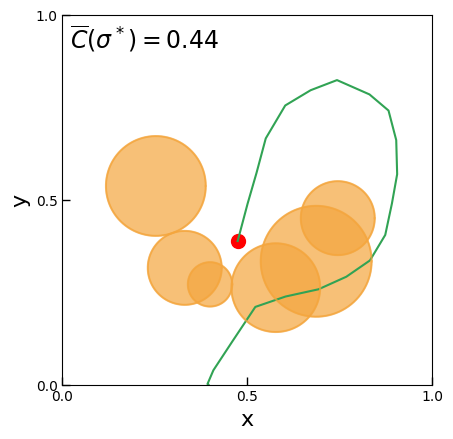

In [18]:
# Visualize the simulation result (single environment)
from dataset.escape_from_u_generator import plot
cost = np.max(np.array(states)[:,1]) - start_pos[1]
plot(states, cost, centers, rads)

## Visualize Result in Batch

In [14]:
from dataset.escape_from_u_generator import plot_multiple
import joblib
import numpy as np
from matplotlib import pyplot as plt

In [19]:
# Visualize the simulation result (multiple environment)
trn_data = joblib.load("dataset_escape_from_u_2d_1024_envs_fixed_obstacles.joblib")
num_envs = 20
sol_path_list = []
cost_list = []
centers_list = []
rads_list = []
for env_idx in range(num_envs):
    sol_path_list.append(trn_data["paths"][-env_idx])
    cost_list.append(trn_data["costs"][-env_idx])
    centers_list.append(trn_data["ellipse_centers"][-env_idx])
    rads_list.append(trn_data["ellipse_radii"][-env_idx])

# generate escape paths for multiple environments
generated_path_list = []
generated_cost_list = []
for env_idx in range(num_envs):
    print(f"Env {env_idx}")
    centers, rads = centers_list[env_idx], rads_list[env_idx]
    rads = rads.reshape(-1,1)
    start_x = sol_path_list[env_idx][0][0]
    start_y = sol_path_list[env_idx][0][1]
    state = np.array([start_x, start_y])  # [y, y_dot, z, z_dot, phi, phi_dot]
    path = inference(state, centers, rads, max_steps=max_steps, take_only_first_action=1)
    generated_path_list.append(path)
    generated_cost_list.append(np.max(path, axis=0)[1] - start_y)


Env 0


Eval: 21it [00:16,  1.24it/s]                        


Env 1


Eval: 21it [00:17,  1.21it/s]                        


Env 2


Eval: 21it [00:18,  1.15it/s]                        


Env 3


Eval: 21it [00:18,  1.11it/s]                        


Env 4


Eval: 21it [00:19,  1.10it/s]                        


Env 5


Eval: 21it [00:19,  1.08it/s]                        


Env 6


Eval: 21it [00:19,  1.07it/s]                        


Env 7


Eval: 21it [00:19,  1.07it/s]                        


Env 8


Eval: 21it [00:19,  1.07it/s]                        


Env 9


Eval: 21it [00:19,  1.06it/s]                        


Env 10


Eval: 21it [00:20,  1.03it/s]                        


Env 11


Eval: 21it [00:19,  1.06it/s]                        


Env 12


Eval: 21it [00:19,  1.06it/s]                        


Env 13


Eval: 21it [00:20,  1.02it/s]                        


Env 14


Eval: 21it [00:19,  1.06it/s]                        


Env 15


Eval: 21it [00:20,  1.04it/s]                        


Env 16


Eval: 21it [00:20,  1.05it/s]                        


Env 17


Eval: 21it [00:19,  1.07it/s]                        


Env 18


Eval: 21it [00:19,  1.07it/s]                        


Env 19


Eval: 21it [00:19,  1.06it/s]                        


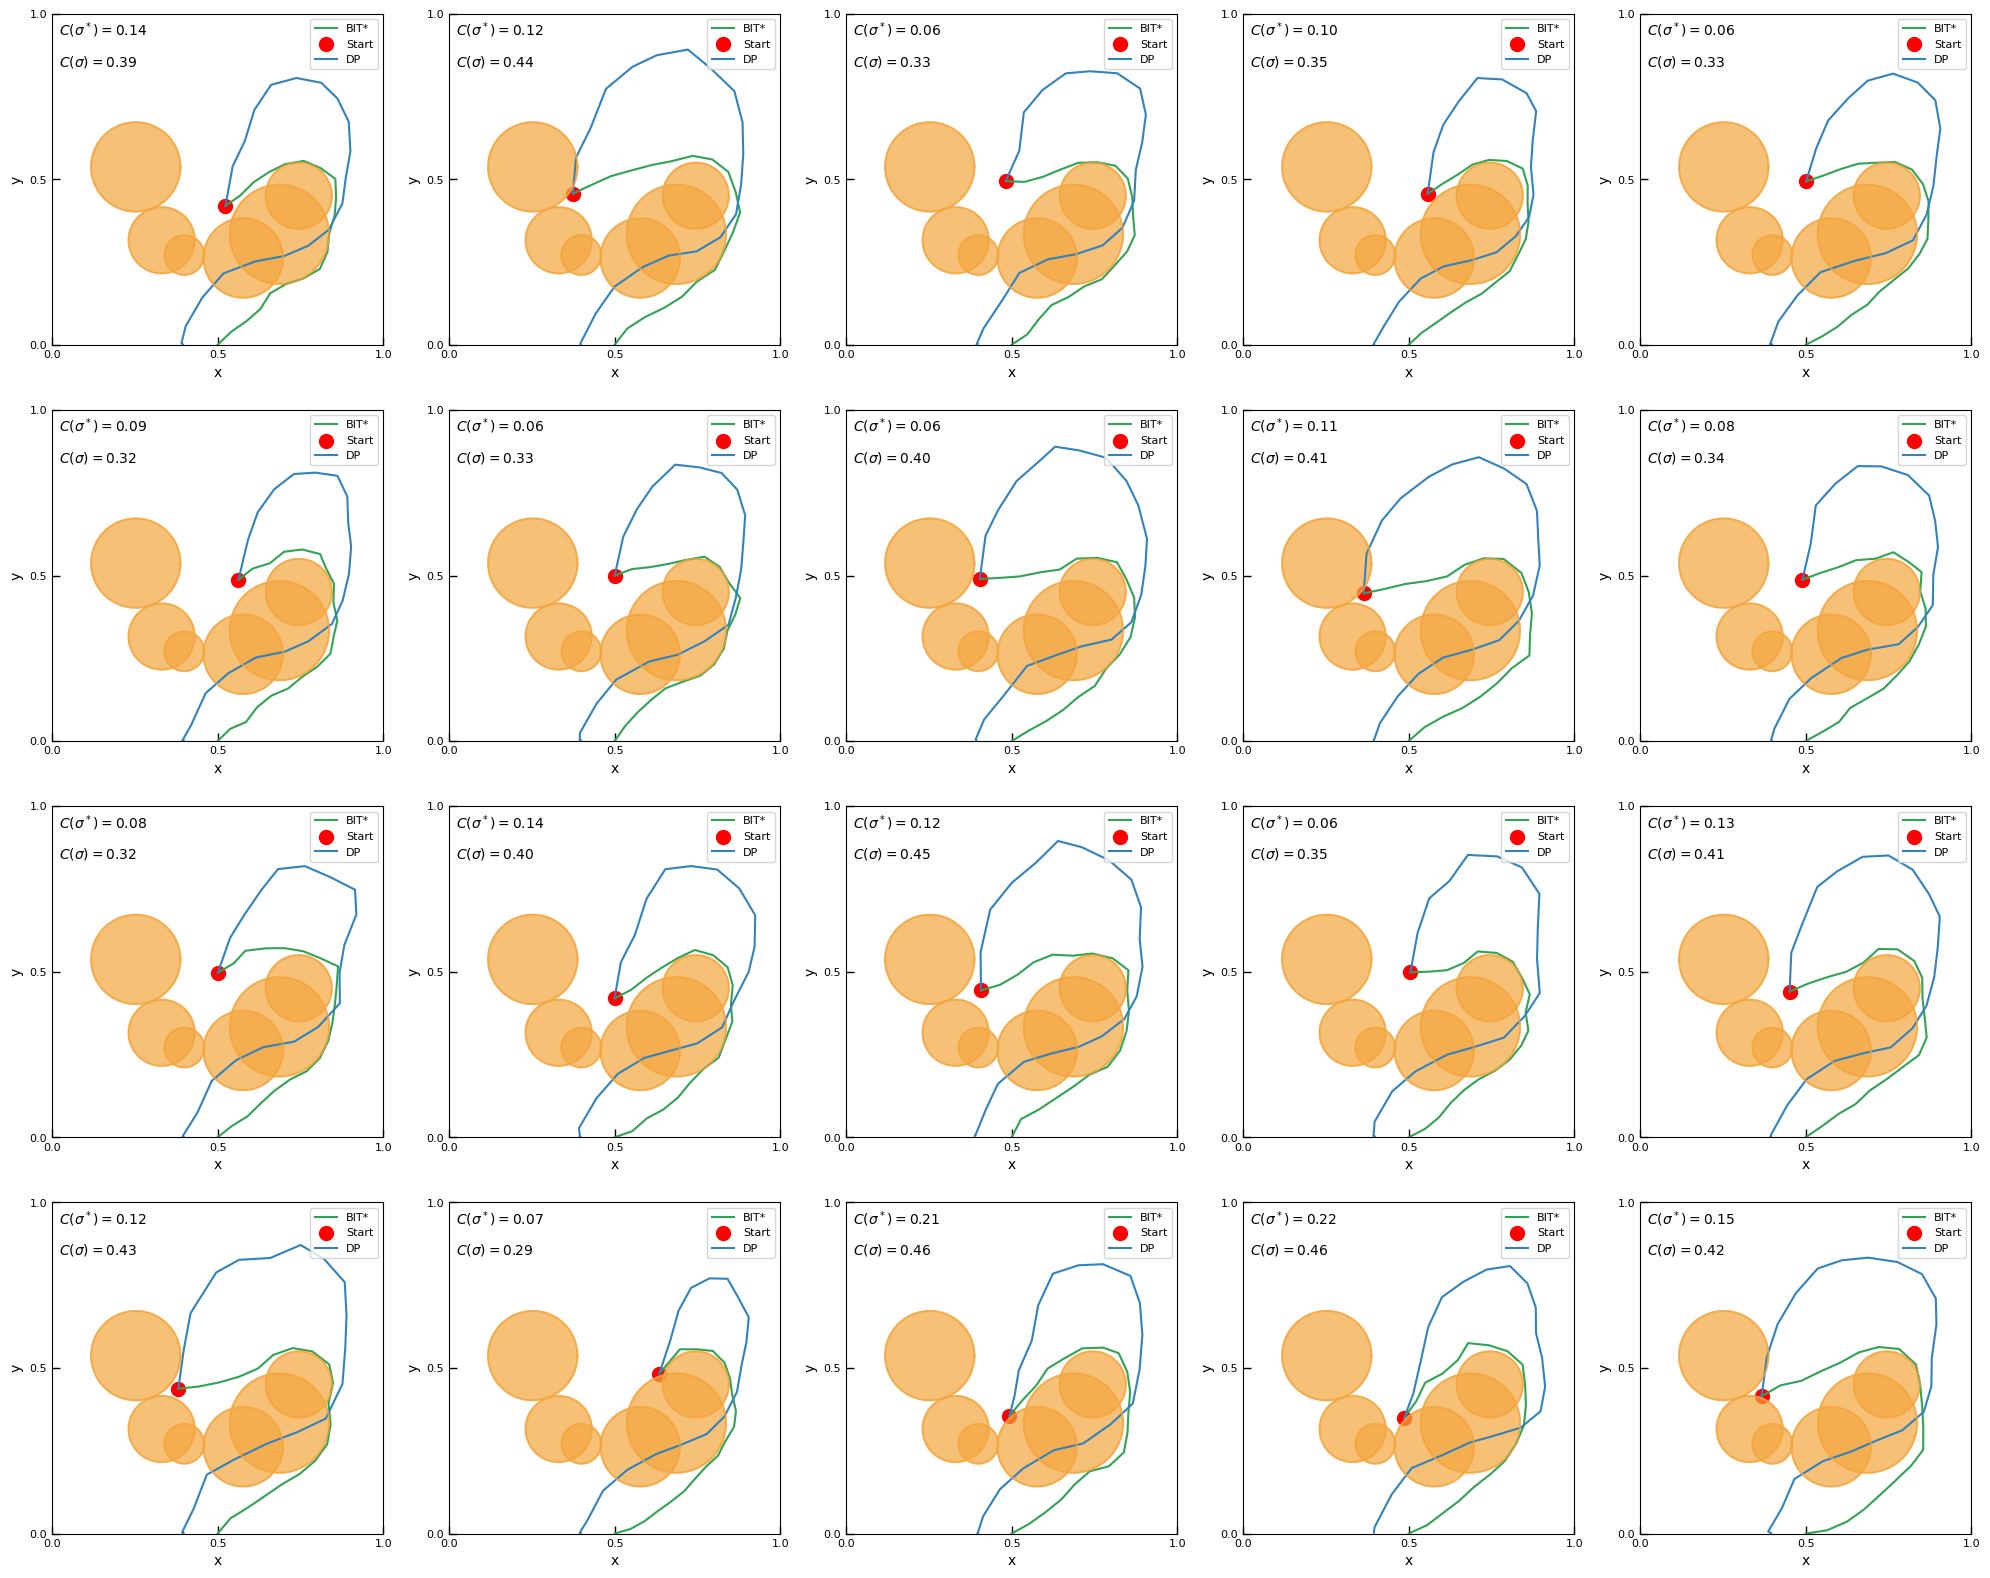

In [20]:

plot_multiple(sol_path_list, cost_list, centers_list, rads_list, generated_path_list, generated_cost_list)
